# Airbnb in Madrid

## 0.1 Load the data

In [153]:
#import libaries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sn
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from IPython import display
import collections
from time import time
from itertools import chain
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
import seaborn as sns
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error

import plotly.graph_objects as go

#from helper import prepare_listings

In [154]:
calendar=pd.read_csv("calendar.csv")
calendar.head(2)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,100411,2020-04-17,f,$60.00,$60.00,2.0,30.0
1,102040,2020-04-18,f,$22.00,$22.00,3.0,90.0


In [155]:
reviews_df=pd.read_csv("reviews.csv")
reviews_df.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,6369,29428,2010-03-14,84790,Nancy,Simon and Arturo have the ultimate location in...
1,6369,31018,2010-03-23,84338,David,Myself and Kristy originally planned on stayin...


In [156]:
listings=pd.read_csv("listings.csv")
listings.head(2)

C:\Users\PC\Documents\Anaconda3\envs\tf-gpu-15\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (43,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,6369,https://www.airbnb.com/rooms/6369,20200417153609,2020-04-18,"Rooftop terrace room , ensuite bathroom",Excellent connection with the AIRPORT and EXHI...,BETTER THAN A HOTEL.Upscale neighboorhood (Met...,Excellent connection with the AIRPORT and EXHI...,none,Nice and definitely non touristic neighborhoo...,...,f,f,flexible,f,f,1,0,1,0,0.61
1,21853,https://www.airbnb.com/rooms/21853,20200417153609,2020-04-18,Bright and airy room,We have a quiet and sunny room with a good vie...,I am living in a nice flat near the centre of ...,We have a quiet and sunny room with a good vie...,none,We live in a leafy neighbourhood with plenty o...,...,f,f,strict_14_with_grace_period,f,f,2,0,2,0,0.49


## 0.2 NA treatment

In [157]:
#check NA values
(listings.isnull().sum()/len(listings)).sort_values(ascending=False)

#drop all the columns with all rows as na
listings=listings.dropna(how="all",axis="columns")

#tdrop columns with more than 60% of na
df_listing_cl=listings.dropna(axis="columns",thresh=listings.shape[0]*0.6,how='all')

#drop all the colums with the word "url" in it.
url_cols=[col for col in df_listing_cl.columns.values if 'url' in col]
df_listing_cl=df_listing_cl.drop(columns=url_cols)

## 0.3 categorical treatment

In [158]:
#transform columns with 1 or 0 
binary_cols=['host_is_superhost','host_has_profile_pic','host_identity_verified','is_location_exact'
             ,'instant_bookable','require_guest_profile_picture','require_guest_phone_verification',
             'has_availability','requires_license','is_business_travel_ready']
df_listing_cl[binary_cols]=np.where(df_listing_cl[binary_cols]=='t', 1, 0)
df_listing_cl[binary_cols]=df_listing_cl[binary_cols].astype(np.uint8)

In [159]:
#some columns are description, etc. Since NLP is beyond of the scope of this project, it will be filled with 1 if there is info in the 
#cell, and 0 y it is null.
cat=['experiences_offered', 'neighborhood_overview', 'transit','description','space','summary']
df_listing_cl[cat]=np.where(df_listing_cl[cat] != "NaN", 1, 0)
df_listing_cl[cat]=df_listing_cl[cat].astype(np.uint8)

In [160]:
#This will help us to filter variables
df_listing_cl[df_listing_cl.select_dtypes(include=["uint8"]).columns]=df_listing_cl[df_listing_cl.select_dtypes(include=["uint8"]).columns].astype("category")


In [161]:
#convert price and extra numeric data that is in a wrong format
for column in ["price","extra_people","cleaning_fee","security_deposit"]:
    df_listing_cl[column]=df_listing_cl[column].replace('[\$,]', '', regex=True).astype(float)

In [162]:
#let's delete unused columns
unused_columns=["host_since","host_location","host_response_time","host_response_rate","host_acceptance_rate",
              "host_verifications","street","calendar_updated","calendar_last_scraped","first_review","last_review",
               "country","country_code","state","market","smart_location","cancellation_policy","reviews_per_month",
               "name","host_name","scrape_id","last_scraped","neighborhood_overview","neighborhood_overview","requires_license",
                "host_neighbourhood","description"]
df_listing_cl=df_listing_cl.drop(columns=unused_columns)
df_listing_cl

,id,summary,space,experiences_offered,transit,host_id,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,...,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,6369,1,1,1,1,13660,1,1.0,1.0,1,...,10.0,10.0,0,0,0,0,1,0,1,0
1,21853,1,1,1,1,83531,0,2.0,2.0,1,...,8.0,9.0,0,0,0,0,2,0,2,0
2,23001,1,1,1,1,82175,0,10.0,10.0,1,...,NaN,NaN,0,0,0,0,6,5,1,0
3,24836,1,1,1,1,101653,1,1.0,1.0,1,...,10.0,10.0,0,0,0,0,1,1,0,0
4,26825,1,1,1,1,114340,0,1.0,1.0,1,...,9.0,9.0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21786,43204745,1,1,1,1,344003812,0,0.0,0.0,1,...,NaN,NaN,1,0,0,0,1,1,0,0
21787,43206188,1,1,1,1,109300368,0,0.0,0.0,1,...,NaN,NaN,1,0,0,0,1,0,1,0
21788,43207981,1,1,1,1,168001538,0,0.0,0.0,1,...,NaN,NaN,1,0,0,0,2,0,2,0
21789,43208445,1,1,1,1,168001538,0,0.0,0.0,1,...,NaN,NaN,1,0,0,0,2,0,2,0


## 0.4 First approach to data

In [163]:
df_listings_affect=df_listing_cl.copy()

In [164]:
df_listings_affect_numeric=df_listings_affect.select_dtypes(exclude=["category","object"])

In [165]:
df_listings_affect_numeric.review_scores_rating.isna().sum()

5050

In [166]:
df_listings_affect_numeric.beds[df_listings_affect_numeric.beds==0]=1

C:\Users\PC\Documents\Anaconda3\envs\tf-gpu-15\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\PC\Documents\Anaconda3\envs\tf-gpu-15\lib\site-packages\pandas\core\generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\PC\Documents\Anaconda3\envs\tf-gpu-15\lib\site-packages\IPython\core\interactiveshell.py:3319: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

In [167]:
df_listings_affect_numeric["price_per_room"]=df_listings_affect_numeric["price"]/df_listings_affect_numeric["bedrooms"]

C:\Users\PC\Documents\Anaconda3\envs\tf-gpu-15\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [168]:
df_listings_affect_numeric["price_per_bed"]=df_listings_affect_numeric["price"]/df_listings_affect_numeric["beds"]

C:\Users\PC\Documents\Anaconda3\envs\tf-gpu-15\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


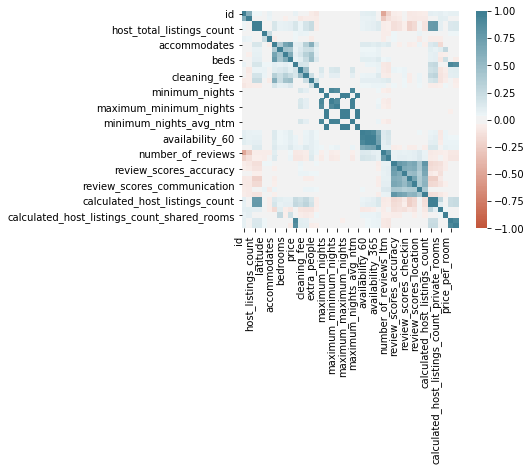

In [169]:
corrMatrix = df_listings_affect_numeric.corr()

ax = sns.heatmap(
    corrMatrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

In [170]:
corrMatrix["review_scores_value"].sort_values()

calculated_host_listings_count                 -0.148260
calculated_host_listings_count_entire_homes    -0.131311
host_listings_count                            -0.112308
host_total_listings_count                      -0.112308
calculated_host_listings_count_private_rooms   -0.082926
host_id                                        -0.071298
availability_365                               -0.058902
id                                             -0.054153
calculated_host_listings_count_shared_rooms    -0.041092
accommodates                                   -0.040263
availability_90                                -0.029320
availability_30                                -0.026609
availability_60                                -0.026290
beds                                           -0.024683
price_per_bed                                  -0.009174
price                                          -0.007540
cleaning_fee                                   -0.005401
maximum_nights                 

In [171]:
# we can see the number of bedrooms inplies hier prices, has it 

## 0.5 Check categorical values

In [172]:
df_listings_affect_category=df_listings_affect.select_dtypes(include=["object","category"])
df_listings_affect_category=df_listings_affect_category.drop(columns=["city","zipcode","neighbourhood","neighbourhood_cleansed"])

In [173]:
#lets one hot encoding the other variables
#encoding property_type

for col in ["bed_type","room_type","property_type","neighbourhood_group_cleansed"]:

    # generate binary values using get_dummies
    df_listings_affect_category = pd.get_dummies(df_listings_affect_category, columns=[col], prefix=[col+"_is"],dtype="uint8")

In [174]:
df_listings_affect_category_with_price=pd.concat([df_listings_affect_category,df_listings_affect["price"]],axis=1)

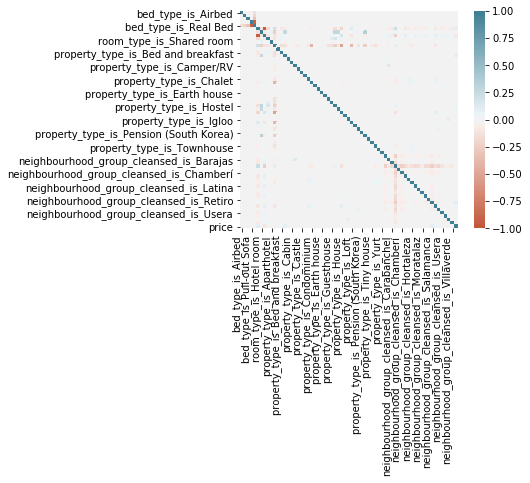

In [175]:
corrMatrix = df_listings_affect_category_with_price.corr()

ax = sns.heatmap(
    corrMatrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

## 0.6 amenties

In [176]:
df_listings_affect_amenities=df_listings_affect["amenities"].str.replace('"',"").str.replace("}","").str.replace("{","").str.split(',',expand=True)

# Add all amenities in dataframe to list
amenities_unique=[df_listings_affect_amenities[x].unique().tolist() for x in df_listings_affect_amenities.columns.values]

# Get unique values of amenities
amenities_unique=set(list(chain.from_iterable(amenities_unique)))
print(amenities_unique)

# Remove '' and None values
amenities_unique.remove('')
amenities_unique.remove(None)

# Create binary amenity columns
for index in range(30):
    for a in amenities_unique:
        df_listings_affect_amenities[a] = 0

for index in range(30):
    for a in amenities_unique:
        df_listings_affect_amenities[a] += np.where(df_listings_affect_amenities[index] == a, 1, 0)

# Drop redundant column
df_listings_affect_amenities.drop(columns=[x for x in range(85)],inplace=True)
df_listings_affect_amenities=df_listings_affect_amenities.astype(np.uint8)

{'', 'Baking sheet', 'Smart TV', 'Memory foam mattress', 'Exercise equipment', 'Beach essentials', 'Heated towel rack', 'Room-darkening shades', 'Accessible-height bed', 'Garden or backyard', 'En suite bathroom', 'Hammock', 'No stairs or steps to enter', 'Extra pillows and blankets', 'Terrace', 'Air conditioning', 'Children’s books and toys', 'Bathtub with bath chair', 'Indoor fireplace', 'Safe', 'Mudroom', 'Heating', 'High chair', 'Doorman', 'Paid parking on premises', 'Stair gates', 'Ceiling fan', 'Cooking basics', 'Standing valet', 'Body soap', 'Iron', 'Wide doorway to guest bathroom', 'Netflix', 'Refrigerator', 'Bed linens', 'Step-free shower', 'Sound system', 'High-resolution computer monitor', 'Disabled parking spot', 'Microwave', 'Self check-in', 'Walk-in shower', 'Cleaning before checkout', 'Bedroom comforts', 'Luggage dropoff allowed', 'Essentials', 'Pocket wifi', 'Stove', 'Smoke detector', 'Flat path to guest entrance', 'Well-lit path to entrance', 'Hangers', 'Buzzer/wireless

In [177]:
# Append amenities columns to original dataframe
df_listings_affect_amenities=df_listings_affect_amenities.join(df_listings_affect["price"],how='left')
# Drop amenities column
#df_listings_affect_amenities.drop(columns='amenities',inplace=True)
df_listings_affect_amenities

,Baking sheet,Smart TV,Memory foam mattress,Exercise equipment,Beach essentials,Heated towel rack,Room-darkening shades,Accessible-height bed,Garden or backyard,En suite bathroom,...,Jetted tub,Wide entrance for guests,Children’s dinnerware,Babysitter recommendations,Balcony,Barbecue utensils,Building staff,Smart lock,Hot water,price
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,70.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,30.0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,50.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,115.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21786,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,43.0
21787,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,19.0
21788,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12.0
21789,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.0


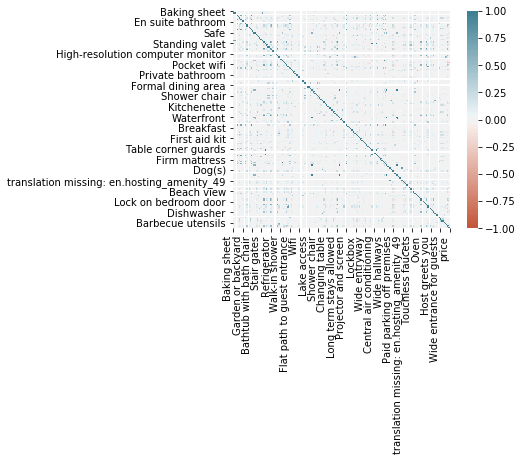

In [178]:
corrMatrix = df_listings_affect_amenities.corr()

ax = sns.heatmap(
    corrMatrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);


In [179]:
corrMatrix["price"].dropna().sort_values()

Essentials                  -0.286616
Kitchen                     -0.167455
Hangers                     -0.124931
Laptop friendly workspace   -0.120245
Hot water                   -0.116936
                               ...   
Air conditioning             0.081272
Safe                         0.095809
Dishwasher                   0.109444
Dryer                        0.126051
price                        1.000000
Name: price, Length: 146, dtype: float64

# 1. How to get good reviews?

In [180]:
df_listing_cl

,id,summary,space,experiences_offered,transit,host_id,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,...,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,6369,1,1,1,1,13660,1,1.0,1.0,1,...,10.0,10.0,0,0,0,0,1,0,1,0
1,21853,1,1,1,1,83531,0,2.0,2.0,1,...,8.0,9.0,0,0,0,0,2,0,2,0
2,23001,1,1,1,1,82175,0,10.0,10.0,1,...,NaN,NaN,0,0,0,0,6,5,1,0
3,24836,1,1,1,1,101653,1,1.0,1.0,1,...,10.0,10.0,0,0,0,0,1,1,0,0
4,26825,1,1,1,1,114340,0,1.0,1.0,1,...,9.0,9.0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21786,43204745,1,1,1,1,344003812,0,0.0,0.0,1,...,NaN,NaN,1,0,0,0,1,1,0,0
21787,43206188,1,1,1,1,109300368,0,0.0,0.0,1,...,NaN,NaN,1,0,0,0,1,0,1,0
21788,43207981,1,1,1,1,168001538,0,0.0,0.0,1,...,NaN,NaN,1,0,0,0,2,0,2,0
21789,43208445,1,1,1,1,168001538,0,0.0,0.0,1,...,NaN,NaN,1,0,0,0,2,0,2,0


In [181]:
df_listings_affect=df_listing_cl.copy()

In [182]:
review=[]
for i in df_listings_affect.columns:
    if "review" in i:
        review.append(i)
        
review.remove("review_scores_value")
review.remove("review_scores_accuracy")
review

['number_of_reviews',
 'number_of_reviews_ltm',
 'review_scores_rating',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location']

In [183]:
price_reviews=df_listings_affect[review]
price_reviews.head()
price_reviews.dropna(how="any")

,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location
0,75,13,98.0,10.0,10.0,10.0,10.0
1,33,0,92.0,9.0,10.0,10.0,8.0
3,68,12,98.0,10.0,10.0,10.0,10.0
4,149,18,94.0,10.0,10.0,9.0,9.0
5,170,10,93.0,10.0,10.0,10.0,10.0
...,...,...,...,...,...,...,...
21600,2,2,100.0,10.0,10.0,10.0,10.0
21601,2,2,100.0,10.0,10.0,10.0,10.0
21602,2,2,100.0,10.0,10.0,10.0,10.0
21656,1,1,100.0,10.0,10.0,10.0,10.0


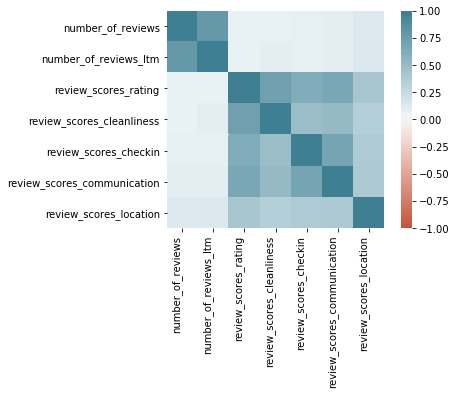

In [184]:
corrMatrix = price_reviews.corr()

ax = sns.heatmap(
    corrMatrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

In [185]:
figure = ax.get_figure().savefig('svm_conf.png',bbox_inches="tight")   

In [186]:
corrMatrix["review_scores_rating"].sort_values(ascending=False)

review_scores_rating           1.000000
review_scores_cleanliness      0.722120
review_scores_communication    0.671632
review_scores_checkin          0.627002
review_scores_location         0.424528
number_of_reviews_ltm          0.077988
number_of_reviews              0.071557
Name: review_scores_rating, dtype: float64

# 2. How is the distribution of the Airbnb?

In [187]:
# does not seem superhost airbnb host are more expensive.

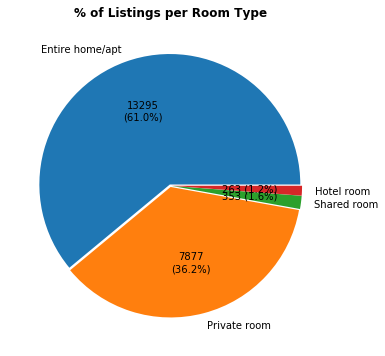

In [188]:
#vemos cuántos de los airbnb son pisos completos
df_listing_cl=df_listing_cl
fig, ax = plt.subplots(figsize=(6,6))
pie_data = (
    df_listing_cl['room_type']
    .value_counts())
(pie_data
 .plot(kind='pie', 
       autopct=lambda v: (
           '{}'.format(int(v/100*sum(pie_data))) +
           '\n' * int(v > 10) + ' ' * int(v <= 10) +
           '({:.1%})'.format(v/100)),
       explode=(0.01, ) * len(pie_data),
       ax=ax))
ax.set_ylabel('')
ax.set_title('% of Listings per Room Type', weight='bold')
plt.show()
fig.savefig('listingperroomtype.png',bbox_inches="tight")   

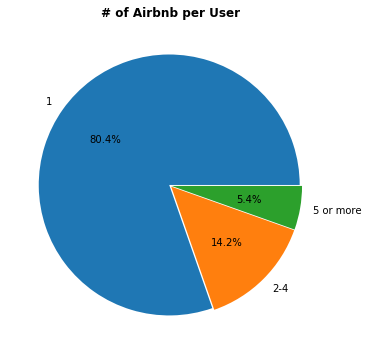

In [189]:

listings_entire_home_or_hotel=df_listing_cl[df_listing_cl["room_type"].isin(["Entire home/apt","Hotel room"])]
listings_entire_home_or_hotel_copy=listings_entire_home_or_hotel
fig, ax = plt.subplots(figsize=(6,6))

listings_entire_home_or_hotel_copy = (
    listings_entire_home_or_hotel_copy
    .groupby('host_id')
    .size())

pie_data = (
    listings_entire_home_or_hotel_copy
    .pipe(pd.cut, bins=[1,2,5,1000], include_lowest=True, right=False,
       labels=['1', '2-4', '5 or more']).value_counts())

pie_data.plot(kind='pie',
              explode=(0.01, ) * len(pie_data),
              autopct=lambda v: (
                  '{}'.format('{:.1%}'.format(v/100))))

ax.set_ylabel('')
ax.set_title('# of Airbnb per User', weight='bold')

plt.show()
fig.savefig('airbnbperuser.png',bbox_inches="tight")   

In [190]:
listings_entire_home_or_hotel_copy.sort_values(ascending=False).head(7)

host_id
102947901    177
247570318    150
28038703     124
99018982     121
206349691    106
32046323      80
107141654     69
dtype: int64

In [191]:
BBox = ((df_listing_cl.longitude.min(),   df_listing_cl.longitude.max(),      
         df_listing_cl.latitude.min(), df_listing_cl.latitude.max()))
print(BBox)

(-3.8639099999999997, -3.52766, 40.33247, 40.562740000000005)


In [192]:
ruh_m = plt.imread('Madrid.png')

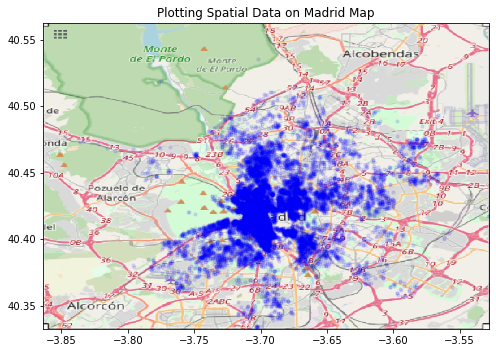

In [193]:
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(df_listing_cl.longitude, df_listing_cl.latitude, zorder=1, alpha= 0.1, c='b', s=10)
ax.set_title('Plotting Spatial Data on Madrid Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

,id,summary,space,experiences_offered,transit,host_id,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,...,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,6369,1,1,1,1,13660,1,1.0,1.0,1,...,10.0,10.0,0,0,0,0,1,0,1,0
1,21853,1,1,1,1,83531,0,2.0,2.0,1,...,8.0,9.0,0,0,0,0,2,0,2,0
2,23001,1,1,1,1,82175,0,10.0,10.0,1,...,NaN,NaN,0,0,0,0,6,5,1,0
3,24836,1,1,1,1,101653,1,1.0,1.0,1,...,10.0,10.0,0,0,0,0,1,1,0,0
4,26825,1,1,1,1,114340,0,1.0,1.0,1,...,9.0,9.0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21786,43204745,1,1,1,1,344003812,0,0.0,0.0,1,...,NaN,NaN,1,0,0,0,1,1,0,0
21787,43206188,1,1,1,1,109300368,0,0.0,0.0,1,...,NaN,NaN,1,0,0,0,1,0,1,0
21788,43207981,1,1,1,1,168001538,0,0.0,0.0,1,...,NaN,NaN,1,0,0,0,2,0,2,0
21789,43208445,1,1,1,1,168001538,0,0.0,0.0,1,...,NaN,NaN,1,0,0,0,2,0,2,0


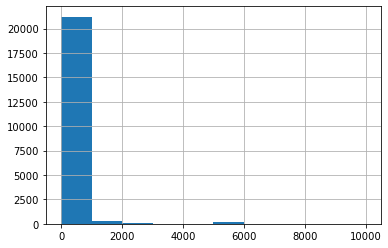

In [194]:
df_listing_cl["price"].hist()
#quitamos los outliers
df_listing_cl=df_listing_cl[df_listing_cl["price"]<300]
df_listing_cl

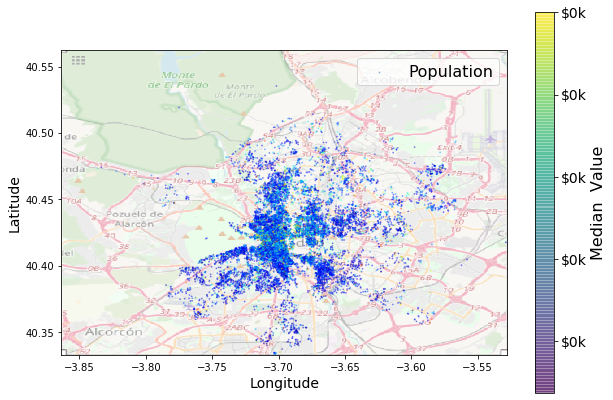

In [195]:
import numpy as np
import matplotlib.image as mpimg
california_img=mpimg.imread('Madrid.png')
ax = df_listing_cl.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=0.7, label="Population",
                       c="price", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=BBox, alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = df_listing_cl["price"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median  Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

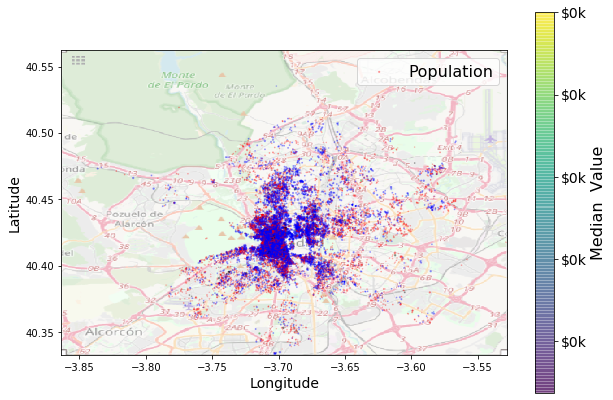

In [197]:
import numpy as np
import matplotlib.image as mpimg
california_img=mpimg.imread('Madrid.png')

colors = {"Private room":'red', 'Entire home/apt':'blue', 'Hotel room':'green', 'Shared room':'black'}


ax = df_listing_cl.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=df_listing_cl.price/100, label="Population",
                       c=df_listing_cl["room_type"].apply(lambda x: colors[x]), cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.3,
                      )
plt.imshow(california_img, extent=BBox, alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = df_listing_cl["price"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median  Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

In [198]:
df_listing_cl.room_type.unique()

array(['Private room', 'Entire home/apt', 'Hotel room', 'Shared room'],
      dtype=object)

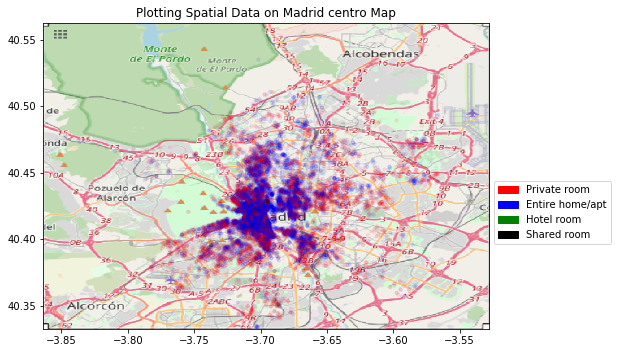

In [199]:
fig, ax = plt.subplots(figsize = (8,7))

colors = {"Private room":'red', 'Entire home/apt':'blue', 'Hotel room':'green', 'Shared room':'black'}


ax.scatter(df_listing_cl.longitude, df_listing_cl.latitude, zorder=1, alpha= 0.07, c=df_listing_cl["room_type"].apply(lambda x: colors[x]), s=10)

red_patch = mpatches.Patch(color='red', label='Private room')
blue_patch = mpatches.Patch(color='blue', label='Entire home/apt')
green_patch = mpatches.Patch(color='green', label='Hotel room')
black_patch = mpatches.Patch(color='black', label='Shared room')


plt.legend( handles=[red_patch,blue_patch,green_patch,black_patch],bbox_to_anchor=(1, 0.5))

ax.set_title('Plotting Spatial Data on Madrid centro Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(california_img, zorder=0, extent = BBox, aspect= 'equal')

(-3.72015, -3.69095, 40.40554, 40.42992)


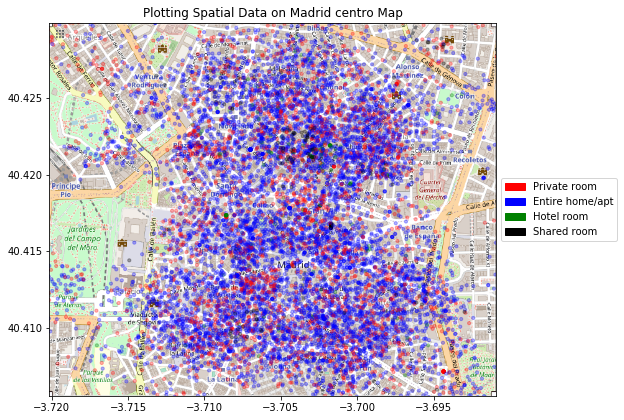

In [200]:
centro=df_listing_cl[df_listing_cl["neighbourhood_group_cleansed"]=="Centro"]

BBox_centro = ((centro.longitude.min(),   centro.longitude.max(),      
         centro.latitude.min(), centro.latitude.max()))
print(BBox_centro)
ruh_m_centro= plt.imread('Madrid_centro.png')
fig, ax = plt.subplots(figsize = (8,7))

colors = {"Private room":'red', 'Entire home/apt':'blue', 'Hotel room':'green', 'Shared room':'black'}


ax.scatter(df_listing_cl.longitude, df_listing_cl.latitude, zorder=1, alpha= 0.3, c=df_listing_cl["room_type"].apply(lambda x: colors[x]), s=10)

red_patch = mpatches.Patch(color='red', label='Private room')
blue_patch = mpatches.Patch(color='blue', label='Entire home/apt')
green_patch = mpatches.Patch(color='green', label='Hotel room')
black_patch = mpatches.Patch(color='black', label='Shared room')


plt.legend( handles=[red_patch,blue_patch,green_patch,black_patch],bbox_to_anchor=(1, 0.5))

ax.set_title('Plotting Spatial Data on Madrid centro Map')
ax.set_xlim(BBox_centro[0],BBox_centro[1])
ax.set_ylim(BBox_centro[2],BBox_centro[3])
ax.imshow(ruh_m_centro, zorder=0, extent = BBox_centro, aspect= 'equal')

In [201]:
df_listing_cl.neighbourhood_group_cleansed.unique()

array(['Chamartín', 'Latina', 'Arganzuela', 'Centro',
       'Fuencarral - El Pardo', 'Salamanca', 'Tetuán',
       'Puente de Vallecas', 'Ciudad Lineal', 'Chamberí', 'Villaverde',
       'Hortaleza', 'Moncloa - Aravaca', 'Carabanchel', 'Retiro',
       'San Blas - Canillejas', 'Villa de Vallecas', 'Barajas', 'Usera',
       'Moratalaz', 'Vicálvaro'], dtype=object)

# 3. reviews

In [202]:
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,6369,29428,2010-03-14,84790,Nancy,Simon and Arturo have the ultimate location in...
1,6369,31018,2010-03-23,84338,David,Myself and Kristy originally planned on stayin...
2,6369,34694,2010-04-10,98655,Marion,We had a great time at Arturo and Simon's ! A ...
3,6369,37146,2010-04-21,109871,Kurt,I very much enjoyed the stay. \r\nIt's a wond...
4,6369,38168,2010-04-26,98901,Dennis,Arturo and Simon are polite and friendly hosts...


In [203]:
reviews_df.date=pd.to_datetime(reviews_df.date)

In [204]:
reviews_df['date'] = pd.to_datetime(reviews_df['date'])  

In [205]:
reviews_df_dates=reviews_df.set_index('date').id

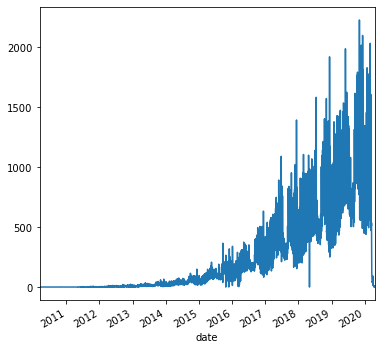

In [206]:
fig, axs = plt.subplots(1,1,figsize=(6,6))


reviews_df.groupby("date").id.count().plot(ax=axs)

fig.savefig("reviewtotaltrend.png")

In [207]:
mask_dates_12 = (reviews_df['date'] > '2012-1-1') & (reviews_df['date'] <= '2013-1-1')
reviews_df_dates_12=reviews_df.loc[mask_dates_12]
reviews_df_dates_12.id.count()

1874

In [208]:
mask_dates_19 = (reviews_df['date'] > '2019-1-1') & (reviews_df['date'] <= '2020-1-1')
reviews_df_dates_19=reviews_df.loc[mask_dates_19]
reviews_df_dates_19.id.count()

299076

In [209]:
((reviews_df_dates_19.id.count()- reviews_df_dates_12.id.count())/reviews_df_dates_12.id.count())*100


15859.231590181429

In [210]:
mask_dates_19 = pd.date_range('2019/01/01','2020/1/1')
mask_dates_19 = (reviews_df['date'] > '2019-1-1') & (reviews_df['date'] <= '2020-1-1')
reviews_df_dates_19=reviews_df.loc[mask_dates_19]


In [211]:
mask_dates_18 = (reviews_df['date'] > '2018-1-1') & (reviews_df['date'] <= '2019-1-1')
reviews_df_dates_18=reviews_df.loc[mask_dates_18]

In [212]:
mask_dates_19 = pd.date_range('2019/01/01','2020/1/1')
mask_dates_19 = (reviews_df['date'] > '2019-1-1') & (reviews_df['date'] <= '2020-1-1')
reviews_df_dates_19=reviews_df.loc[mask_dates_19]

In [213]:
mask_dates_18 = (reviews_df['date'] > '2018-1-1') & (reviews_df['date'] <= '2019-1-1')
reviews_df_dates_18=reviews_df.loc[mask_dates_18]

In [214]:
mask_dates_17 = (reviews_df['date'] > '2017-1-1') & (reviews_df['date'] <= '2018-1-1')
reviews_df_dates_17=reviews_df.loc[mask_dates_17]

In [215]:
mask_dates_16 = (reviews_df['date'] > '2016-1-1') & (reviews_df['date'] <= '2017-1-1')
reviews_df_dates_16=reviews_df.loc[mask_dates_16]

In [216]:
reviews_df

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,6369,29428,2010-03-14,84790,Nancy,Simon and Arturo have the ultimate location in...
1,6369,31018,2010-03-23,84338,David,Myself and Kristy originally planned on stayin...
2,6369,34694,2010-04-10,98655,Marion,We had a great time at Arturo and Simon's ! A ...
3,6369,37146,2010-04-21,109871,Kurt,I very much enjoyed the stay. \r\nIt's a wond...
4,6369,38168,2010-04-26,98901,Dennis,Arturo and Simon are polite and friendly hosts...
...,...,...,...,...,...,...
824413,43052741,621323875,2020-03-30,164630569,Angel,"Todo muy bien, muy limpio y la atención recibi..."
824414,43052839,621227900,2020-03-29,216767398,J& Ev,Nos encantó el alojamiento! En pleno centro de...
824415,43052839,621323869,2020-03-30,164725697,Carlos,TODO EXCELENTE
824416,43119993,622122088,2020-04-10,343391868,Maria Fernanda,Muy atento


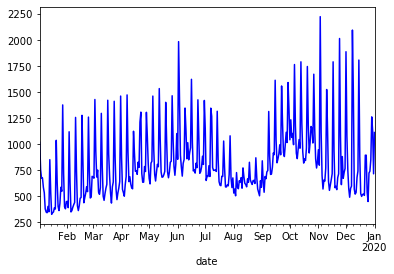

In [217]:
ax2=reviews_df_dates_19.groupby("date").id.count().plot(kind="line",c="blue")
ax2

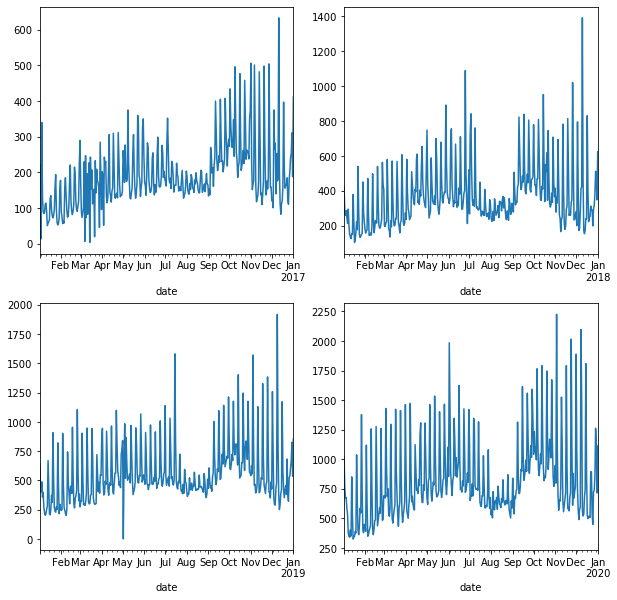

In [218]:
fig, axs = plt.subplots(2, 2,figsize=(10,10))


reviews_df_dates_16.groupby("date").id.count().plot(ax=axs[0,0])
reviews_df_dates_17.groupby("date").id.count().plot(ax=axs[0,1])
reviews_df_dates_18.groupby("date").id.count().plot(ax=axs[1,0])
reviews_df_dates_19.groupby("date").id.count().plot(ax=axs[1,1])

fig.savefig("fig4trend.png")

In [ ]:
axs[1,1]